<center>
    <img src="https://i.postimg.cc/Y0gXWHN9/Abstract-Segmented-Abstract.png" 
         alt ="Abstract-Segmented-Abstract" 
         style='width: 60%;'>
    
</center>


## 🎯 Objective

Medical research paper abstracts can be challenging to read due to their complex wording and dense representation in a single paragraph. However, what if there was a way to segment these abstracts to optimize them for speed reading and improve their readability (skimmable)?

The purpose of this notebook is to explore building an Natural Language Processing (NLP) model with PyTorch to segment text lines of abstracts from medical research papers in order to improve the readability of these said abstracts. For this project, we will utilize the pretrained [DeBERTa-v3 Base](https://huggingface.co/microsoft/deberta-v3-base) model available on [HuggingFace](https://huggingface.co/).

## 📁 Dataset
The dataset used to train the NLP model is based of a paper titled **"PubMed 20k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts"**, published in October 2017. 

In [1]:
! pip -q install torchview
# ! pip install torchtext

In [2]:
import re
import random
import os
import glob
import time
import gc
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
# import torchtext
import torch.optim.lr_scheduler as lr_scheduler

from torchinfo import summary
from torch import nn
from torch.utils.data import (Dataset, DataLoader)

from tqdm.notebook import tqdm
from transformers import (AutoTokenizer, DebertaV2Model)
from typing import Dict, List, Tuple

# from scikitplot.metrics import plot_roc
from sklearn.preprocessing import (OneHotEncoder, LabelEncoder) 
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, precision_recall_fscore_support,
    accuracy_score, top_k_accuracy_score, f1_score, 
    matthews_corrcoef, confusion_matrix, ConfusionMatrixDisplay
)

2025-04-29 08:52:55.296686: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745916775.489246      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745916775.545979      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
os.environ["TOKENIZERS_PARALLELISM"] = "false"
plt.style.use('dark_background')

In [4]:
class CFG:
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    NUM_DEVICES = torch.cuda.device_count()
    NUM_WORKERS = os.cpu_count()
    MODEL_NAME = 'microsoft/deberta-v3-base'
    
    LR = 0.001
    APPLY_SHUFFLE = False
    SEED = 768
    TARGET ='target'
    MAX_LENGTH = 68
    NUM_CLASSES = 5
    EPOCHS = 10
    PATIENS = 1
    THRESHOLD = 0.01
    BATCH_SIZE = (
        256 if torch.cuda.device_count() < 2 
        else (256 * torch.cuda.device_count())
    )
    
    # Define paths
    DATASET_PATH = "/kaggle/working/pubmed-rct/PubMed_20k_RCT/"
    TRAIN_CSV = '/kaggle/input/pubmed-200k-rtc/PubMed_20k_RCT/train.csv'
    VAL_CSV = '/kaggle/input/pubmed-200k-rtc/PubMed_20k_RCT/dev.csv'
    TEST_CSV = '/kaggle/input/pubmed-200k-rtc/PubMed_20k_RCT/test.csv'


# 1 | Loading the Data

In [5]:
def reduce_memory(df:pd.DataFrame, verbose:bool=True) -> pd.DataFrame:
    original_memory = (df.memory_usage().sum()) / (1024 ** 2)

    for column in df.columns:
        column_dtype = df[column].dtype

        if (column_dtype != object) and (column_dtype != str):
            if (str(column_dtype) + '______')[:3] == 'int':
                df[column] = df[column].astype(np.int32)
            if (str(column_dtype) + '______')[:5] == 'float':
                df[column] = df[column].astype(np.float32)

    if verbose:
        print('-----------------------------------------------------')
        print(f'Memory usage of dataframe:\t\t{original_memory:.2f} MB')

        altered_memory = df.memory_usage().sum() / 1024**2
        print(f'Memory usage after dtype conversion:\t{altered_memory:.2f} MB')

        memory_variance = 100 * (original_memory - altered_memory) / original_memory
        print(f'Memory consumption decreased by:\t{memory_variance:.2f}%')
        print('-----------------------------------------------------')

    return df

In [6]:
# Clone the dataset directory
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25 (from 1)
Receiving objects: 100% (39/39), 177.08 MiB | 55.59 MiB/s, done.
Resolving deltas: 100% (15/15), done.


In [7]:
# Inspect the PubMed_200K dataset directory
!ls pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.zip


In [8]:
def get_raw_data(filepath):
    with open(filepath) as f:
        return f.readlines()

In [9]:
# For this model we'll use the 20k dataset no preprocessing
dataset_dir = "/kaggle/working/pubmed-rct/PubMed_20k_RCT/"

In [10]:
# Load the data
train_data = get_raw_data(dataset_dir + 'train.txt')

In [11]:
# View the first 20 lines from the dataset text file
train_data[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of 6 weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at 12 weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of 125 patients with primary knee OA were randomized 1:1 ; 63 received 7.5 mg/day of prednisolone and 62 received placebo for 6 weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( 0-100 mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and 6-min walk distance ( 6MWD ) .\n',
 'METHODS\tSerum levels of interleukin 1 ( IL-1 ) , IL-6 , tumor necrosis factor ( TNF )

In [12]:
def preprocess_raw_data(filepath):
    raw_data = get_raw_data(filepath)
    abstract_data = ''
    abstract_samples = []
    abstract_id = 0

    for line in raw_data:
        if line.startswith('###'): # check if current line is an abstract start (line -> ###[abstract_id]\n)
            abstract_id = int(line.replace('###', '').replace('\n', '')) # get abstract id
            abstract_data = ''

        elif line.isspace(): # check if current line is an abstract end (line -> '\n')
            abstract_data_split = abstract_data.splitlines()
            
            for abstract_line_number, abstract_line in enumerate(abstract_data_split):
                line_data = {} # store lines in dictionary
                target_text_split = abstract_line.split("\t") # split target label from text 
                
                line_data["abstract_id"] = abstract_id # get abstract id
                line_data["line_id"] = f'{abstract_id}_{abstract_line_number}_{len(abstract_data_split)}' # create id for each line
                line_data["abstract_text"] = target_text_split[1] # get target text and lower it
                line_data["line_number"] = abstract_line_number # get line number in the abstract
                line_data["total_lines"] = len(abstract_data_split) # get total count for abstract lines (counter starts at 1)
                line_data['current_line'] = f'{abstract_line_number}_{len(abstract_data_split)}' # embed line_number & total_lines into one feature 
                line_data["target"] = target_text_split[0] # get target label
                
                abstract_samples.append(line_data) # append line data to abstract samples list

        else: # if the above conditions aren't fulfilled, the line is a abstract text line (line -> [TARGET]\t[abstract_text])
            abstract_data += line

    return abstract_samples

In [13]:
%%time
# Get train data from file and preprocess it
train_samples = preprocess_raw_data(dataset_dir + "train.txt")

CPU times: user 340 ms, sys: 100 ms, total: 440 ms
Wall time: 440 ms


In [14]:
%%time
# Get dev/validation data from file and preprocess it
val_samples = preprocess_raw_data(dataset_dir + "dev.txt")

CPU times: user 53.8 ms, sys: 17.2 ms, total: 71 ms
Wall time: 69.8 ms


In [15]:
%%time
# Get test data from file and preprocess it
test_samples = preprocess_raw_data(dataset_dir + "test.txt")

CPU times: user 54 ms, sys: 14 ms, total: 68.1 ms
Wall time: 67.3 ms


In [16]:
train_count = len(train_samples)
val_count = len(val_samples)
test_count = len(test_samples)
total = train_count + val_count + test_count

In [17]:
print(f'Train samples count:\t\t{train_count}')
print(f'Dev/validation samples count:\t{val_count}')
print(f'Test samples count:\t\t{test_count}')

print(f'\nTotal samples:\t\t\t{total}')

Train samples count:		180040
Dev/validation samples count:	30212
Test samples count:		30135

Total samples:			240387


In [18]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [19]:
# View train samples
train_df.head(5)

,abstract_id,line_id,abstract_text,line_number,total_lines,current_line,target
0,24293578,24293578_0_12,To investigate the efficacy of 6 weeks of dail...,0,12,0_12,OBJECTIVE
1,24293578,24293578_1_12,A total of 125 patients with primary knee OA w...,1,12,1_12,METHODS
2,24293578,24293578_2_12,Outcome measures included pain reduction and i...,2,12,2_12,METHODS
3,24293578,24293578_3_12,Pain was assessed using the visual analog pain...,3,12,3_12,METHODS
4,24293578,24293578_4_12,Secondary outcome measures included the Wester...,4,12,4_12,METHODS


In [20]:
# Group all datasets into dictionary
ds = {
    'train_df': train_df, 
    'val_df'  : val_df, 
    'test_df' : test_df
}

# View dataset info
for _ in list(ds.keys()):
    print('====================================')
    print(f'Viewing {_} info:\n')
    print(ds[_].info(show_counts=True), '\n')

Viewing train_df info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180040 entries, 0 to 180039
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   abstract_id    180040 non-null  int64 
 1   line_id        180040 non-null  object
 2   abstract_text  180040 non-null  object
 3   line_number    180040 non-null  int64 
 4   total_lines    180040 non-null  int64 
 5   current_line   180040 non-null  object
 6   target         180040 non-null  object
dtypes: int64(3), object(4)
memory usage: 9.6+ MB
None 

Viewing val_df info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30212 entries, 0 to 30211
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   abstract_id    30212 non-null  int64 
 1   line_id        30212 non-null  object
 2   abstract_text  30212 non-null  object
 3   line_number    30212 non-null  int64 
 4   total_lines    30212

In [21]:
# Calculate total samples
train_size = len(train_df)
val_size = len(val_df)
test_size = len(test_df)
total = train_size + val_size + test_size

# View the counts
print(f'train samples count:\t\t{train_size}\t({(100 * train_size/total):.2f}%)')
print(f'validation samples count:\t{val_size}\t({(100 * val_size/total):.2f}%)')
print(f'test samples count:\t\t{test_size}\t({(100 * test_size/total):.2f}%)')
print('================================================')
print(f'TOTAL:\t\t\t\t{total}\t({(100 * total/total):.2f}%)')

train samples count:		180040	(74.90%)
validation samples count:	30212	(12.57%)
test samples count:		30135	(12.54%)
TOTAL:				240387	(100.00%)


# 2 | Data Exploration

<a id='2.1'></a>
### Inspect Train Data Target Distribution

In [22]:
# Distribution of labels in training data
train_df.target.value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

In [23]:
def plot_bar(x_data, y_data, orientation, color_pallette, axis):
    bar_plot = sns.barplot(
        x=x_data,y=y_data,
        orient=orientation, palette=color_pallette,
        ax=axis
    );

    for container in bar_plot.containers:
        bar_plot.bar_label(container, fmt='%.0f', fontsize=14);
        
    return bar_plot

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


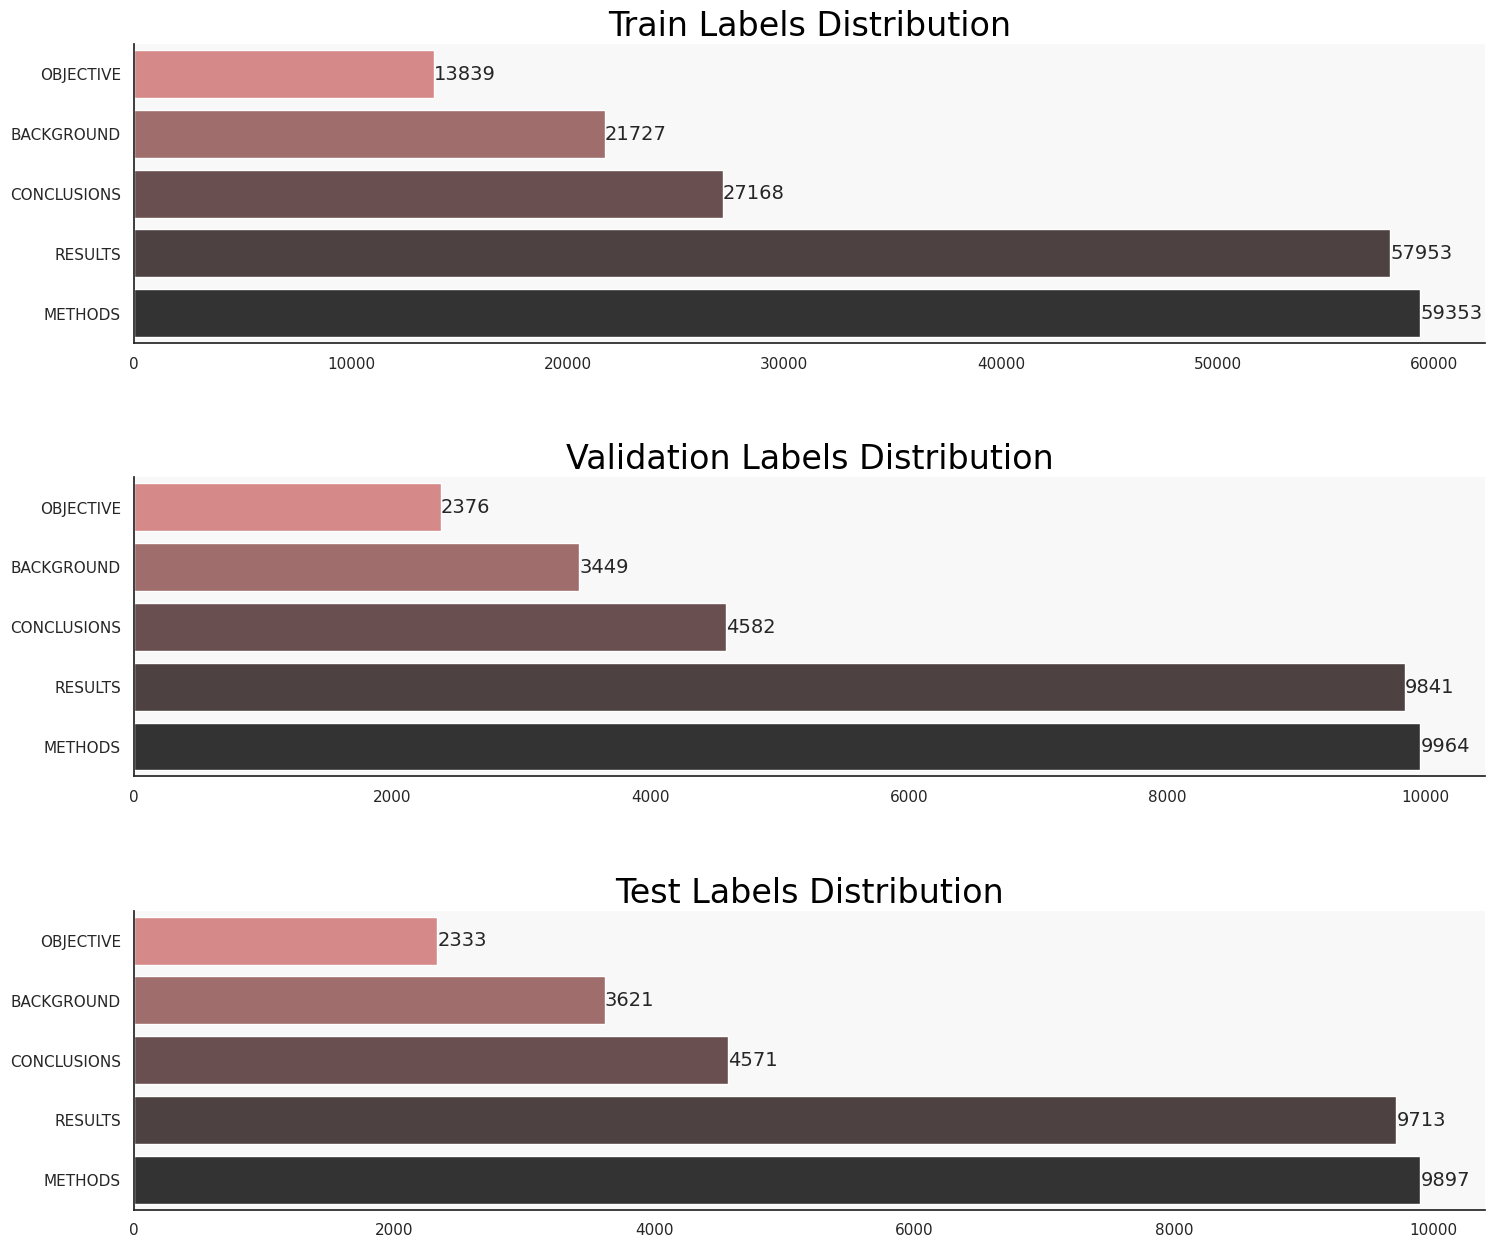

In [75]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(16, 14))
fig.tight_layout(pad=6.0)

custom_palette = ["#e27c7c", "#a86464", "#6d4b4b", "#503f3f", "#333333"]

# Train Distribution
ax1.set_title('Train Labels Distribution', fontsize=24, color='black')
train_distribution = train_df['target'].value_counts().sort_values()
plot_bar(
    x_data=train_distribution.values, 
    y_data=list(train_distribution.keys()), 
    orientation="h", 
    color_pallette=custom_palette, 
    axis=ax1
)

# Validation Distribution
ax2.set_title('Validation Labels Distribution', fontsize=24, color='black')
val_distribution = val_df['target'].value_counts().sort_values()
plot_bar(
    x_data=val_distribution.values, 
    y_data=list(val_distribution.keys()), 
    orientation="h", 
    color_pallette=custom_palette, 
    axis=ax2
)

# Test Distribution
ax3.set_title('Test Labels Distribution', fontsize=24, color='black')
test_distribution = test_df['target'].value_counts().sort_values()
plot_bar(
    x_data=test_distribution.values, 
    y_data=list(test_distribution.keys()), 
    orientation="h", 
    color_pallette=custom_palette, 
    axis=ax3
)

sns.despine()
plt.show()


<div class="alert alert-block alert-info">
<h3>Observation</h3>
The dataset is imbalanced (number of samples per class are not roughly the same). This is generally a problem when training a model as this generally introduces overfitting or underfitting for the minority classes.
<br><br>
Methods to deal with this issue is to use upsampling or downsampling techniques or randomly removing samples of the oversampled classes or just to get more data for the undersampled classes. Other methods also includes cross-validation which involves splitting the dataset into folds for improved model training and validation. 
<br><br>
However, due to the computational requirements we will not implement such techniques in order to avoid introducing more dependencies.
</div>

<a id='2.2'></a>
### Analyse Token & Character Counts

In [25]:
train_df['character_count'] = [len(_.replace(' ', '')) for _ in train_df['abstract_text']]

train_df['token_count'] = [len(_.split(' ')) for _ in train_df['abstract_text']]

train_df

,abstract_id,line_id,abstract_text,line_number,total_lines,current_line,target,character_count,token_count
0,24293578,24293578_0_12,To investigate the efficacy of 6 weeks of dail...,0,12,0_12,OBJECTIVE,234,49
1,24293578,24293578_1_12,A total of 125 patients with primary knee OA w...,1,12,1_12,METHODS,117,27
2,24293578,24293578_2_12,Outcome measures included pain reduction and i...,2,12,2_12,METHODS,97,15
3,24293578,24293578_3_12,Pain was assessed using the visual analog pain...,3,12,3_12,METHODS,54,14
4,24293578,24293578_4_12,Secondary outcome measures included the Wester...,4,12,4_12,METHODS,175,35
...,...,...,...,...,...,...,...,...,...
180035,26227186,26227186_7_12,For the absolute change in percent atheroma vo...,7,12,7_12,RESULTS,342,95
180036,26227186,26227186_8_12,"For PAV , a significantly greater percentage o...",8,12,8_12,RESULTS,131,28
180037,26227186,26227186_9_12,Both strategies had acceptable side effect pro...,9,12,9_12,RESULTS,112,18
180038,26227186,26227186_10_12,"Compared with standard statin monotherapy , th...",10,12,10_12,CONCLUSIONS,198,30


In [26]:
# Get 98th percentile for tokens used 
train_df['token_count'].quantile(0.98)

68.0

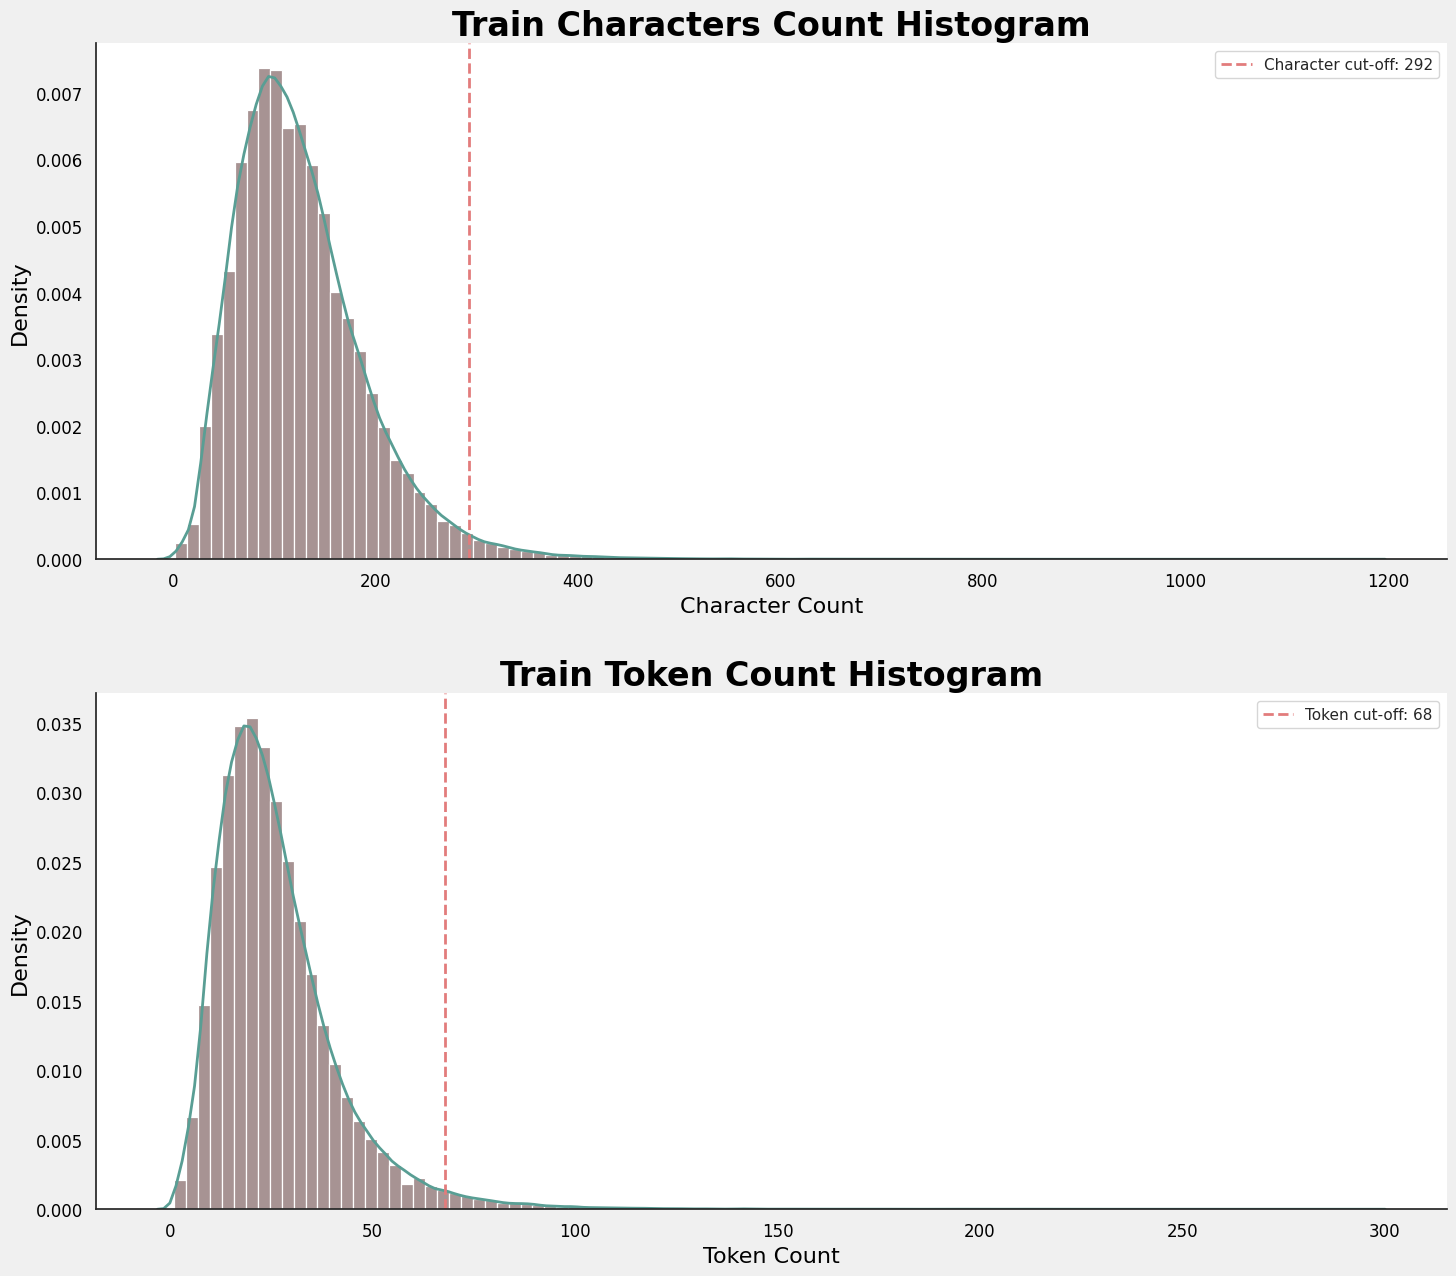

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set theme
sns.set_theme(style="white")

# Custom colors
hist_color = "#6d4b4b"    # histogram color
kde_color = "#599e94"     # KDE curve color
vline_color = "#e27c7c"   # vertical line color

# Create figure
fig, (ax1, ax2) = plt.subplots(2, figsize=(16, 14))
fig.patch.set_facecolor('#f0f0f0')  # Light gray background
fig.tight_layout(pad=6.0)

# === Train Characters Count Histogram ===
ax1.set_title('Train Characters Count Histogram', fontsize=24, weight='bold', color='black')

# Plot histogram
sns.histplot(
    data=train_df,
    x='character_count',
    bins=100,
    color=hist_color,
    ax=ax1,
    stat="density",
    alpha=0.6
)

# Overlay KDE manually
sns.kdeplot(
    data=train_df,
    x='character_count',
    color=kde_color,
    ax=ax1,
    linewidth=2
)

# Character count cut-off line
char_cutoff = train_df['character_count'].quantile(0.98)
ax1.axvline(
    x=char_cutoff,
    color=vline_color,
    linestyle='--',
    linewidth=2,
    label=f'Character cut-off: {int(char_cutoff)}'
)
ax1.legend()
ax1.set_xlabel('Character Count', fontsize=16, color='black')
ax1.set_ylabel('Density', fontsize=16, color='black')
ax1.tick_params(colors='black', labelsize=12)

# === Train Token Count Histogram ===
ax2.set_title('Train Token Count Histogram', fontsize=24, weight='bold', color='black')

# Plot histogram
sns.histplot(
    data=train_df,
    x='token_count',
    bins=100,
    color=hist_color,
    ax=ax2,
    stat="density",
    alpha=0.6
)

# Overlay KDE manually
sns.kdeplot(
    data=train_df,
    x='token_count',
    color=kde_color,
    ax=ax2,
    linewidth=2
)

# Token count cut-off line
token_cutoff = train_df['token_count'].quantile(0.98)
ax2.axvline(
    x=token_cutoff,
    color=vline_color,
    linestyle='--',
    linewidth=2,
    label=f'Token cut-off: {int(token_cutoff)}'
)
ax2.legend()
ax2.set_xlabel('Token Count', fontsize=16, color='black')
ax2.set_ylabel('Density', fontsize=16, color='black')
ax2.tick_params(colors='black', labelsize=12)

sns.despine()
plt.show()


In [28]:
percentiles_list = [0.25, 0.50, 0.75, 0.90, 0.94, 0.98, .99, 1.0]
percentiles = [train_df['token_count'].quantile(_) for _ in percentiles_list]

print('Token Count by Percentile:')
print('================================')
for p, p_tokens in zip(percentiles_list, percentiles):
    print(f'{p*100}% percentile:\t{int(p_tokens)} tokens')
print('================================')

Token Count by Percentile:
25.0% percentile:	16 tokens
50.0% percentile:	23 tokens
75.0% percentile:	33 tokens
90.0% percentile:	45 tokens
94.0% percentile:	52 tokens
98.0% percentile:	68 tokens
99.0% percentile:	80 tokens
100.0% percentile:	296 tokens


<div class="alert alert-block alert-info">
<h3>Observation</h3>
We see that 98% of abstract lines consist of 68 or less tokens. Lines which have more than this number of tokens only account for 2% of the total number of training samples. This implies that 68 tokens should be enough to cover most abstract lines which tokenizing the abstract texts for training and inference.
</div>

<a id='2.3'></a>
### Inspect Token Count Distribution by Target

In [29]:
# Group samples by target
query = train_df.groupby('target')
target_list = sorted(list(train_df['target'].drop_duplicates()))
target_count = len(target_list)

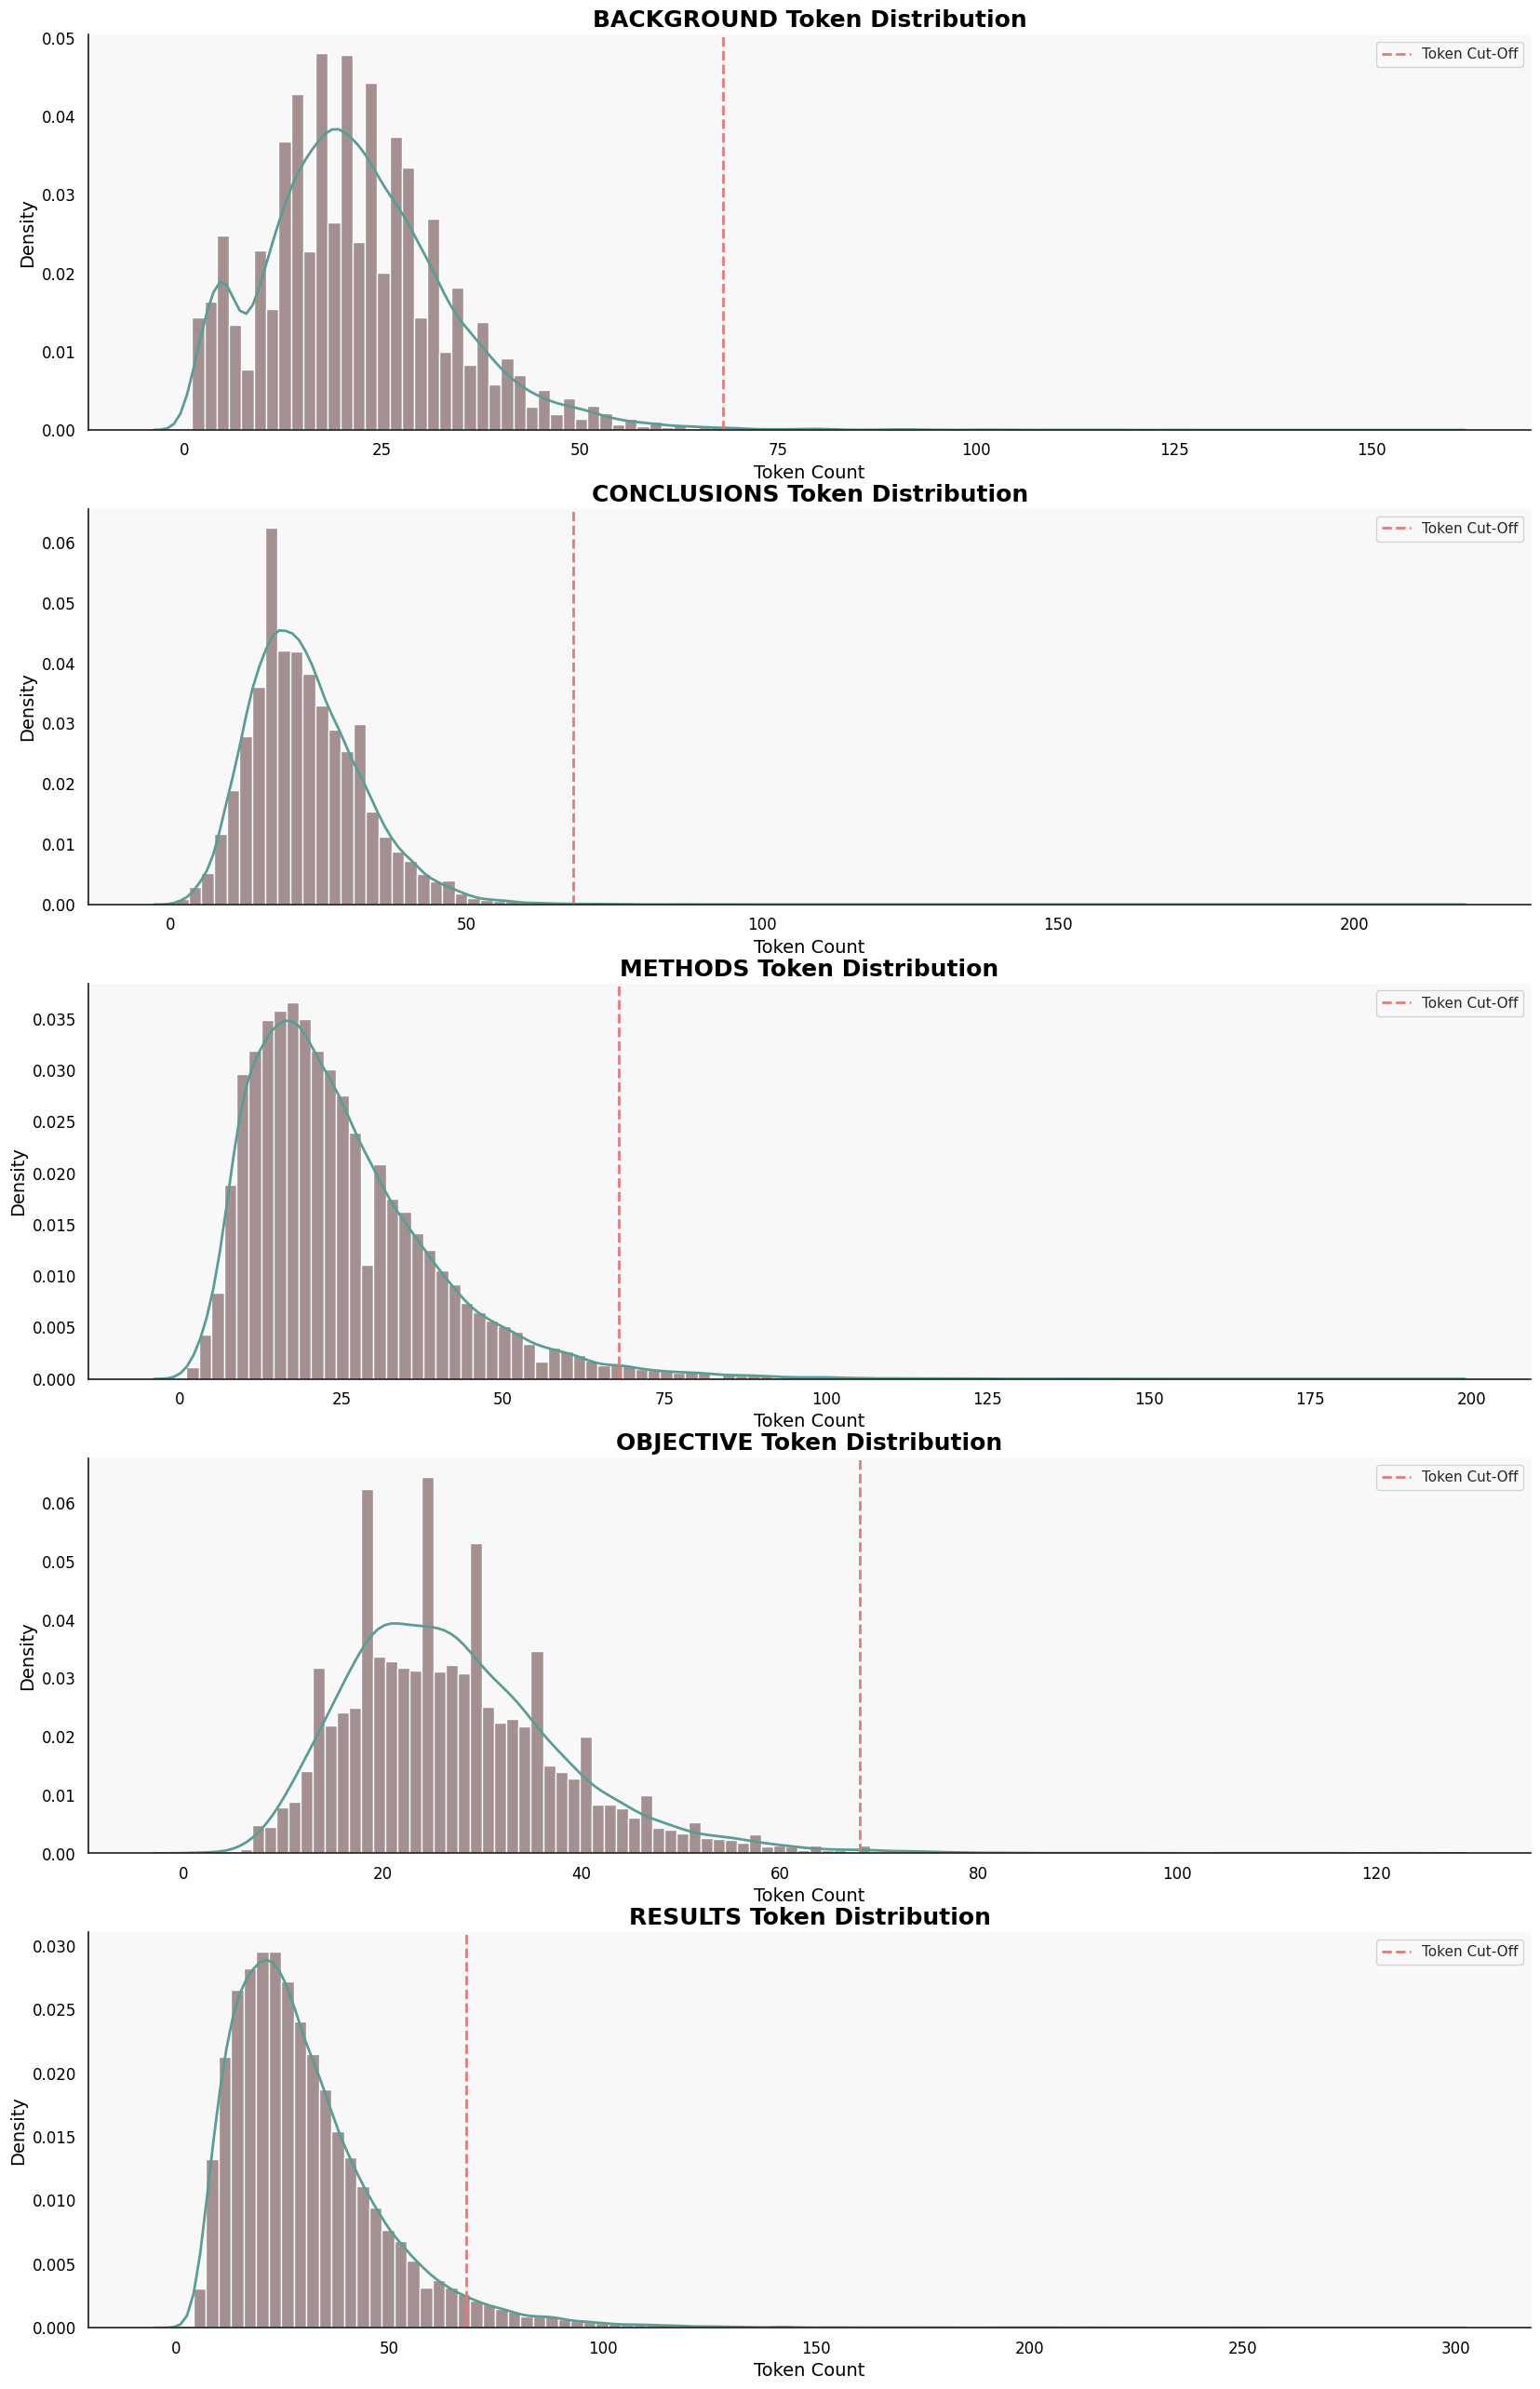

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Custom colors
hist_color = "#6d4b4b"
kde_color = "#599e94"
vline_color = "#e27c7c"

# Set global style
sns.set_theme(style="white")
plt.rcParams['axes.facecolor'] = '#f8f8f8'  # Light background

# Create the figure
fig = plt.figure(figsize=(20, 32))
fig.tight_layout(pad=6.0)

# Loop through target classes
for idx in range(target_count):
    ax = plt.subplot(target_count, 1, idx + 1)
    ax.set_title(f'{target_list[idx]} Token Distribution', fontsize=18, weight='bold', color='black')

    # Histogram
    sns.histplot(
        data=query.get_group(target_list[idx])['token_count'],
        kde=False,
        bins=100,
        color=hist_color,
        stat="density",
        alpha=0.6,
        ax=ax
    )

    # KDE overlay
    sns.kdeplot(
        data=query.get_group(target_list[idx])['token_count'],
        color=kde_color,
        linewidth=2,
        ax=ax
    )

    # Cut-off line
    ax.axvline(
        x=CFG.MAX_LENGTH,
        color=vline_color,
        linestyle='--',
        linewidth=2,
        label='Token Cut-Off'
    )

    # Aesthetics
    ax.legend()
    ax.set_xlabel('Token Count', fontsize=14, color='black')
    ax.set_ylabel('Density', fontsize=14, color='black')
    ax.tick_params(colors='black', labelsize=12)

sns.despine()
plt.show()


<div class="alert alert-block alert-info">
<h3>Observation</h3>
Notice that most samples for each target group consists of samples with 68 or less tokens. This validates our choice of the maximum number of tokens we should use for tokenizing the abstract lines.
</div>

# 3 | Transfer Learning Model: DeBERTa-V3
<br>

<center>
    <img src="https://d3i71xaburhd42.cloudfront.net/2b9024235bc7a601cd7b7127e2577b372e4a3d7d/2-Figure1-1.png" 
         alt ="Fig. 1" 
         style='width: 40%;'>
    <figcaption>
            <a href='https://www.semanticscholar.org/paper/Neural-Networks-for-Joint-Sentence-Classification-Dernoncourt-Lee/2b9024235bc7a601cd7b7127e2577b372e4a3d7d/figure/0'>SemanticScholar | Neural Networks for Joint Sentence Classification in Medical Paper Abstracts Fig. 1</a>
    </figcaption>
</center>

<br><br>


However, for this notebook's model we'll only implement a token embedding layer by using the  [DeBERTa-v3 by Microsoft](https://huggingface.co/microsoft/deberta-v3-base) from [HuggingFace🤗](https://huggingface.co/) for the following reasons:

- It out performs RoBERTa and BERT on a majority of Natural Language Understanding (NLU) tasks.
- Our goal is to produce similar or better results with our current model in comparison to what is achieved in the original paper (see above).

<br>

### Original DeBERTa

DeBERTa, short for Decoding-enhanced BERT with disentangled attention, is a type of transformer-based language model released by Microsoft Research. 

DeBERTa, improved on the [BERT (Bidirectional Encoder Representations from Transformers)](https://huggingface.co/docs/transformers/model_doc/bert) and RoBERTa models utilising two novel techniques: **Disentangled Attention Mechanism** & **Enhanced Mask Decoder**.

The **Disentangled Attention Mechanism** characterizes each word using two separate vectors to encode its content and position respectively. This allows the model to capture better the relationships between words and their positions in a sentence. The **Improved Mask Decoder** replaces the SoftMax layer to predict masked tokens during model pre-training.


### DeBERTa V3
**DeBERTa-v3** improves the original model by introducing two new ideas. First, replacing mask language modeling (MLM) with replaced token detection (RTD), which improves the model's learning capability. Second, introducing Gradient-Disentangled Embedding Sharing (GDES) which improves its performance.

Researchers found that sharing information with the previous method actually hindered the model's performance since different layers of the model were trying to learn different objectives. The vanilla embedding sharing technique used in another language model known as [ELECTRA](https://huggingface.co/docs/transformers/model_doc/electra) reduced the efficiency and performance of the model. Hence, the researchers introduced GDES, which improves both the efficiency and quality of the pre-trained model.

For more information, see the following:
> - [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805)
> - [DeBERTa: Decoding-enhanced BERT with Disentangled Attention](https://arxiv.org/abs/2006.03654)
> - [DeBERTaV3: Improving DeBERTa using ELECTRA-Style Pre-Training with Gradient-Disentangled Embedding Sharing](https://arxiv.org/abs/2111.09543)
> - [ELECTRA: Pre-training Text Encoders as Discriminators Rather Than Generators](https://arxiv.org/abs/2003.10555)

In [31]:
# Get DeBERTa Tokenizer
tokenizer = (
    AutoTokenizer
    .from_pretrained(CFG.MODEL_NAME)
)

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [32]:
# Get model
backbone_model = (
    DebertaV2Model
    .from_pretrained(CFG.MODEL_NAME)
)

# Freeze Model Parameters
for param in backbone_model.parameters():
    param.requires_grad = False

# Push model onto GPU
backbone_model = backbone_model.to(CFG.DEVICE)

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

In [33]:
class DeBERTaV3Model(nn.Module):
    def __init__(self, backbone_model, name='deberta-v3-base', 
                 num_classes=CFG.NUM_CLASSES, device=CFG.DEVICE):
        super(DeBERTaV3Model, self).__init__()
        self.backbone_model = backbone_model
        self.device = device
        self.num_classes = num_classes
        self.name = name
        
        self.current_line_stream = nn.Sequential(
            nn.Linear(in_features=1, out_features=16, bias=True),
            nn.GELU(),
        ).to(device)
        
        self.total_lines_stream = nn.Sequential(
            nn.Linear(in_features=1, out_features=16, bias=True),
            nn.GELU(),
        ).to(device)
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=0.2, inplace=True), 
            nn.Linear(in_features=800, out_features=256, bias=True),
            nn.GELU(),
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(in_features=256, out_features=self.num_classes, bias=False)
        ).to(device)
    
    def mean_pooling(self, inputs, outputs):
        input_mask_expanded = (
            inputs['attention_mask']
            .squeeze()
            .unsqueeze(-1)
            .expand(outputs.last_hidden_state.size())
            .float()
        )
        sum_embeddings = torch.sum(
            outputs.last_hidden_state * input_mask_expanded, 1
        )
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask

        return mean_embeddings
    
    def forward(self, tokens, line_number, total_lines):
        backbone_output = self.backbone_model(**tokens)
        pooled_output = self.mean_pooling(tokens, backbone_output)
        
        line_number_out = self.current_line_stream(
            line_number.view(line_number.size(0), -1).to(dtype=torch.float32)
        )
        total_lines_out = self.total_lines_stream(
            total_lines.view(total_lines.size(0), -1).to(dtype=torch.float32)
        )
        
        concat_layer = torch.cat((pooled_output, line_number_out, total_lines_out), dim=1)

        model_output = self.classifier(concat_layer)
        
        return model_output

In [34]:
# Define Model Params
deberta_params = {
    'backbone_model'    : backbone_model,
    'name'              : 'deberta-v3-base',
    'device'            : CFG.DEVICE
}

# Generate Model
deberta_model = DeBERTaV3Model(**deberta_params)

# If using GPU T4 x2 setup, use this:
if CFG.NUM_DEVICES > 1:
    deberta_model = nn.DataParallel(deberta_model)

In [35]:
deberta_model

DataParallel(
  (module): DeBERTaV3Model(
    (backbone_model): DebertaV2Model(
      (embeddings): DebertaV2Embeddings(
        (word_embeddings): Embedding(128100, 768, padding_idx=0)
        (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): DebertaV2Encoder(
        (layer): ModuleList(
          (0-11): 12 x DebertaV2Layer(
            (attention): DebertaV2Attention(
              (self): DisentangledSelfAttention(
                (query_proj): Linear(in_features=768, out_features=768, bias=True)
                (key_proj): Linear(in_features=768, out_features=768, bias=True)
                (value_proj): Linear(in_features=768, out_features=768, bias=True)
                (pos_dropout): Dropout(p=0.1, inplace=False)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): DebertaV2SelfOutput(
                (dense): Linear(in_features=768, out_featur


# 4 | Build Data Pipeline For Training & Testing
<br>

In order to train the model, we need to setup an input pipeline to load, preprocess and feed the input tokenized texts to the model. This pipeline is required as tokenizing all texts at once may cause an out of memory error to be raised. We also use a large batch size for efficient gpu memory allocation and to speedup the training process.

For this pipeline, we'll use PyTorch's data API to contruct a dataloader and custom dataset/pipeline to tokenize our texts for training and inference. We'll also setup a text processor to filter any bad characters, emoji, links and other unwanted artifacts from the texts.


In [36]:
def text_processor(text):
    
    # -----------------------------------------------------
    # Source: https://stackoverflow.com/questions/33404752/removing-emojis-from-a-string-in-python
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    # -----------------------------------------------------
    non_ascii_pattern = re.compile(r"[^\x00-\x7F]+", flags=re.UNICODE)
    digit_pattern = re.compile('[0-9]', flags=re.UNICODE)
    
    # -----------------------------------------------------
    # Source: https://stackoverflow.com/questions/21932615/regular-expression-for-remove-link
    link_pattern = re.compile('(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)', flags=re.UNICODE)
    # -----------------------------------------------------
    
    # Remove emojis
    preprocessed_text = emoji_pattern.sub(r'', text)
    # Remoce non-ascii characters
    preprocessed_text = non_ascii_pattern.sub(r'', preprocessed_text)
    # Replace numbers with '@' sign
    preprocessed_text = digit_pattern.sub(r'#', preprocessed_text)
    # Remove web links 
    preprocessed_text = link_pattern.sub(r'', preprocessed_text)
    
    return preprocessed_text

In [37]:
class PubMedDataset(Dataset):
    def __init__(self, df:pd.DataFrame, tokenizer, 
                 max_length=64, text_filter=None) -> None:
        super().__init__()
        
        self.texts = df['abstract_text'].to_list()
        self.line_numbers = df['line_number'].to_list()
        self.total_abstract_lines = df['total_lines'].to_list()
        self.labels = df['target'].to_list()
        
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.text_filter = text_filter
        
        self.classes = sorted(list(df['target'].unique()))
        self.class_to_idx = {cls_name: _ for _, cls_name in enumerate(self.classes)}
        
    def tokenize_text(self, text):
        tokenize_params = {
            'text'                  : text,
            'add_special_tokens'    : True, 
            'truncation'            : True,
            'padding'               : 'max_length', 
            'max_length'            : self.max_length,
            'return_tensors'        : 'pt'
        }
        
        return self.tokenizer(**tokenize_params)
        
    def __len__(self) -> int:
        return self.texts.__len__()
    
    def __getitem__(self, index:int) -> Tuple[torch.Tensor, int]:
        text = (self.texts[index])
        
        # Transform if necessary
        if self.text_filter:
            text = self.text_filter(text)
        
        text = self.tokenize_text(text)
        text = {k:text[k].squeeze() for k in text.keys()}
        
        line_number = float(self.line_numbers[index])
        total_lines = float(self.total_abstract_lines[index])
        
        class_name = self.labels[index]
        class_idx = self.class_to_idx[class_name]
        
        return (text, line_number, total_lines), class_idx

<a id=4.1></a>
### Build DataLoaders from Custom Datasets

In [38]:
def generate_pipeline(
    df, model_tokenizer, filter_fn,
    max_len=CFG.MAX_LENGTH, 
    batch_size=CFG.BATCH_SIZE,
    num_workers=CFG.NUM_WORKERS,
    shuffle=CFG.APPLY_SHUFFLE) -> Tuple[Dataset, DataLoader]:
    
    # Build Custom Dataset
    ds = PubMedDataset(
        df, model_tokenizer, 
        max_length=max_len,
        text_filter=filter_fn
    )

    # Generate DataLoader
    loader = DataLoader(
        dataset=ds, 
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle
    )
    
    return ds, loader

In [39]:
# Build train dataset & dataloader
train_ds, train_loader = generate_pipeline(
    train_df,
    tokenizer,
    text_processor,
    max_len=CFG.MAX_LENGTH,
    batch_size=CFG.BATCH_SIZE,
    num_workers=CFG.NUM_WORKERS,
    shuffle=CFG.APPLY_SHUFFLE
)

# Build val dataset & dataloader
val_ds, val_loader = generate_pipeline(
    val_df,
    tokenizer,
    text_processor,
    max_len=CFG.MAX_LENGTH,
    batch_size=CFG.BATCH_SIZE,
    num_workers=CFG.NUM_WORKERS,
    shuffle=False
)

# Build test dataset & dataloader
test_ds, test_loader = generate_pipeline(
    test_df, 
    tokenizer,
    text_processor,
    max_len=CFG.MAX_LENGTH,
    batch_size=CFG.BATCH_SIZE,
    num_workers=CFG.NUM_WORKERS,
    shuffle=False
)


# 5 | Train Model

<br>

To train this model we'll use Crossentropy as the loss function since this is a classification problem for binary labels. As for the optimizer, we'll use the Adam optimizer with 0.001 as the (default) learning rate. The only metrics we'll track during the training of the model will be the loss and accuracy metrics.


<br>

### Define Loss & Optimizer

In [40]:
# Define Loss Function
loss_fn = nn.CrossEntropyLoss(
    label_smoothing=0.1
)

# Define Optimizer
optimizer = torch.optim.Adam(
    deberta_model.parameters(),
    lr=CFG.LR
)

# Define Scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer, 
    mode='min',
    patience=CFG.PATIENS,
    threshold=CFG.THRESHOLD,
    threshold_mode='abs',
    verbose=True
)

<a id='5.2'></a>
### Define Epoch Execution (Train Step)

In [41]:
def execute_epoch(
    model:torch.nn.Module,
    dataloader:torch.utils.data.DataLoader,
    optimizer:torch.optim.Optimizer,
    loss_fn:torch.nn.Module,
    device:torch.device) -> Tuple[float, float]:
    
    # Set model into training mode
    model.train()
    
    # Initialize train loss & accuracy
    train_loss, train_acc = 0, 0
    
    # Execute training loop over train dataloader
    for batch, (X, y) in enumerate(tqdm(dataloader)):
        # Push data onto target device
        tokens, current_line, total_lines = X[0], X[1], X[2]
        tokens = {k:tokens[k].to(device) for k in tokens.keys()}
        current_line = current_line.to(device)
        total_lines = total_lines.to(device)
        y = y.to(device)
        
        # Feed-forward and compute metrics
        logits = model(tokens, current_line, total_lines)
        loss = loss_fn(logits, y)
        train_loss += loss.item() 
        
        # Reset Gradients & Backpropagate Loss
        optimizer.zero_grad()
        loss.backward()
        
        # Update Model Gradients
        optimizer.step()
        
        # Compute Batch Metrics
        y_pred = torch.softmax(logits, dim=1)
        predicted_class = torch.argmax(y_pred, dim=1)
        train_acc += (predicted_class == y).sum().item() / len(y_pred)
        
        # Release data from memory
        del X, y
        garb = gc.collect()
        
    # Compute Step Metrics
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    
    return train_loss, train_acc

<a id='5.3'></a>
### Define Evaluation Step

In [42]:
def evaluate(
    model:torch.nn.Module,
    dataloader:torch.utils.data.DataLoader,
    loss_fn:torch.nn.Module,
    device:torch.device) -> Tuple[float, float]:
    
    # Set model into eval mode
    model.eval()
    
    # Initialize eval loss & accuracy
    eval_loss, eval_acc = 0, 0
    
    # Active inferene context manager
    with torch.inference_mode():
        # Execute eval loop over dataloader
        for batch, (X, y) in enumerate(dataloader):
            # Push data onto target device
            tokens, current_line, total_lines = X[0], X[1], X[2]
            tokens = {k:tokens[k].to(device) for k in tokens.keys()}
            current_line = current_line.to(device)
            total_lines = total_lines.to(device)
            y = y.to(device)

            # Feed-forward and compute metrics
            logits = model(tokens, current_line, total_lines)
            loss = loss_fn(logits, y)
            eval_loss += loss.item() 

            # Compute Batch Metrics
            y_pred = torch.softmax(logits, dim=1)
            predicted_class = torch.argmax(y_pred, dim=1)
            eval_acc += (predicted_class == y).sum().item() / len(y_pred)
            
            # Release data from memory
            del X, y
            garb = gc.collect()
        
    # Compute Step Metrics
    eval_loss = eval_loss / len(dataloader)
    eval_acc = eval_acc / len(dataloader)
    
    return eval_loss, eval_acc

<a id='5.4'></a>
### Construct Training Loop

In [43]:
def train(
    model:torch.nn.Module,
    train_dataloader:torch.utils.data.DataLoader,
    eval_dataloader:torch.utils.data.DataLoader,
    optimizer:torch.optim.Optimizer,
    scheduler:torch.optim.lr_scheduler,
    loss_fn:torch.nn.Module,
    epochs:int,
    device:torch.device) -> Dict[str, List]:
    
    # Initialize training session
    session = {
        'loss'          : [],
        'accuracy'      : [],
        'eval_loss'     : [],
        'eval_accuaracy': []
    }
    
    # Training loop
    for epoch in tqdm(range(epochs)):
        # Execute Epoch
        print(f'\nEpoch {epoch + 1}/{epochs}')
        train_loss, train_acc = execute_epoch(
            model, 
            train_dataloader, 
            optimizer, 
            loss_fn, 
            device
        )
        
        # Evaluate Model
        eval_loss, eval_acc = evaluate(
            model, 
            eval_dataloader,
            loss_fn, 
            device
        )
        
        # Execute schedular step
        current_lr = 0
        if scheduler: 
            scheduler.step(eval_loss)
            current_lr = optimizer.param_groups[0]['lr']
        
        # Log Epoch Metrics
        log_text = f'loss: {train_loss:.4f} - acc: {train_acc:.4f} - eval_loss: {eval_loss:.4f} - eval_acc: {eval_acc:.4f}'

        if scheduler: 
            print(log_text + f' - lr: {current_lr}')
        else:
            print(log_text)
        
        # Record Epoch Metrics
        session['loss'].append(train_loss)
        session['accuracy'].append(train_acc)
        session['eval_loss'].append(eval_loss)
        session['eval_accuaracy'].append(eval_acc)
        
    # Return Session Metrics
    return session

<a id='5.5'></a>
### Train DeBERTa Model

In [44]:
# Train the model 
print('Training DeBERTa-V3 Base Model')
print(f'Train on {len(train_df)} samples, validate on {len(val_df)} samples.')
print('----------------------------------')

session_config = {
    'model'               : deberta_model,
    'train_dataloader'    : train_loader,
    'eval_dataloader'     : val_loader,
    'optimizer'           : optimizer,
    'scheduler'           : scheduler,
    'loss_fn'             : loss_fn,
    'epochs'              : CFG.EPOCHS,
    'device'              : CFG.DEVICE
}

session_history = train(**session_config)

Training DeBERTa-V3 Base Model
Train on 180040 samples, validate on 30212 samples.
----------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]


Epoch 1/10


  0%|          | 0/352 [00:00<?, ?it/s]

loss: 0.7861 - acc: 0.8052 - eval_loss: 0.6643 - eval_acc: 0.8649 - lr: 0.001

Epoch 2/10


  0%|          | 0/352 [00:00<?, ?it/s]

loss: 0.6987 - acc: 0.8519 - eval_loss: 0.6501 - eval_acc: 0.8708 - lr: 0.001

Epoch 3/10


  0%|          | 0/352 [00:00<?, ?it/s]

loss: 0.6779 - acc: 0.8621 - eval_loss: 0.6334 - eval_acc: 0.8813 - lr: 0.001

Epoch 4/10


  0%|          | 0/352 [00:00<?, ?it/s]

loss: 0.6686 - acc: 0.8663 - eval_loss: 0.6289 - eval_acc: 0.8829 - lr: 0.001

Epoch 5/10


  0%|          | 0/352 [00:00<?, ?it/s]

loss: 0.6606 - acc: 0.8699 - eval_loss: 0.6299 - eval_acc: 0.8780 - lr: 0.0001

Epoch 6/10


  0%|          | 0/352 [00:00<?, ?it/s]

loss: 0.6480 - acc: 0.8757 - eval_loss: 0.6127 - eval_acc: 0.8895 - lr: 0.0001

Epoch 7/10


  0%|          | 0/352 [00:00<?, ?it/s]

loss: 0.6466 - acc: 0.8766 - eval_loss: 0.6105 - eval_acc: 0.8910 - lr: 0.0001

Epoch 8/10


  0%|          | 0/352 [00:00<?, ?it/s]

loss: 0.6458 - acc: 0.8763 - eval_loss: 0.6104 - eval_acc: 0.8913 - lr: 1e-05

Epoch 9/10


  0%|          | 0/352 [00:00<?, ?it/s]

loss: 0.6438 - acc: 0.8781 - eval_loss: 0.6105 - eval_acc: 0.8911 - lr: 1e-05

Epoch 10/10


  0%|          | 0/352 [00:00<?, ?it/s]

loss: 0.6444 - acc: 0.8778 - eval_loss: 0.6102 - eval_acc: 0.8913 - lr: 1.0000000000000002e-06


In [ ]:
def predict(
    model:nn.Module, 
    sample_loader:torch.utils.data.DataLoader,
    device:torch.device) -> np.ndarray:
    
    # Set model into eval mode
    model.eval()
    
    predictions = []
    
    # Active inferene context manager
    with torch.inference_mode():
        # Execute eval loop over dataloader
        for batch, (X, y) in enumerate(tqdm(sample_loader)):
            # Push data onto target device
            tokens, current_line, total_lines = X[0], X[1], X[2]
            tokens = {k:tokens[k].to(device) for k in tokens.keys()}
            current_line = current_line.to(device)
            total_lines = total_lines.to(device)
            y = y.to(device)

            # Feed-forward and compute metrics
            y_pred = model(tokens, current_line, total_lines) 

            # Compute Batch Metrics
            predicted_probs = torch.softmax(y_pred, dim=1).cpu().numpy()
            
            # Record prediction
            predictions.append(predicted_probs)
        
    return np.vstack(predictions)

In [ ]:
# Generate test sample probabilities 
test_probs = predict(deberta_model, test_loader, CFG.DEVICE)

In [47]:
# Generate test sample preditions 
test_preds = np.argmax(test_probs, axis=1)

In [48]:
# Create Model directory
model_name = 'abstract_segmentation_model'
model_path = '/kaggle/working/model/'
os.mkdir(model_path)

In [49]:
# Save Model 
torch.save(deberta_model, model_path + model_name + '.pth')


# 6 | Performance Analysis


<br>

Since this is a classification problem we'll make use of some well known classification metrics. Hence, we'll make use of the Scikit Learn library to inspect the model. We'll also use the following to inspect the model:

- [Classification Report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report)
- [Accuracy Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score) 
- [Top k Accuracy Score (top 3 in this case)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.top_k_accuracy_score.html#sklearn.metrics.top_k_accuracy_score)
- [F1-score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score) 
- [Precision](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score)
- [Recall](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score)
- [Matthews Correlation Coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html)


<a id='6.1'></a>
### Plot Model Performance Records

In [50]:
def plot_training_curves(history):
    
    loss = np.array(history['loss'])
    val_loss = np.array(history['eval_loss'])

    accuracy = np.array(history['accuracy'])
    val_accuracy = np.array(history['eval_accuaracy'])

    epochs = range(len(history['loss']))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Plot loss
    ax1.plot(epochs, loss, label='training_loss', marker='o', color='C5')
    ax1.plot(epochs, val_loss, label='eval_loss', marker='o', color='C6')
    ax1.set_xticks(np.arange(0, len(epochs), step=1))

    ax1.fill_between(
        epochs, loss, val_loss, 
        where=(loss > val_loss), 
        color='C5', alpha=0.3, 
        interpolate=True
    )
    ax1.fill_between(
        epochs, loss, val_loss, 
        where=(loss < val_loss), 
        color='C6', alpha=0.3, 
        interpolate=True
    )

    ax1.set_title('Loss (Lower Means Better)', fontsize=18)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.legend(fontsize=12)

    # Plot accuracy
    ax2.plot(epochs, accuracy, label='training_accuracy', marker='o', color='C5')
    ax2.plot(epochs, val_accuracy, label='eval_accuracy', marker='o', color='C6')
    ax2.set_xticks(np.arange(0, len(epochs), step=1))
    
    ax2.fill_between(
        epochs, accuracy, val_accuracy, 
        where=(accuracy > val_accuracy), 
        color='C5', alpha=0.3, 
        interpolate=True
    )
    ax2.fill_between(
        epochs, accuracy, val_accuracy, 
        where=(accuracy < val_accuracy), 
        color='C6', alpha=0.3, 
        interpolate=True
    )

    ax2.set_title('Accuracy (Higher Means Better)', fontsize=18)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.legend(fontsize=12);
    
    sns.despine();
    
    return

In [51]:
# Convert history dict to DataFrame
session_history_df = pd.DataFrame(session_history)
session_history_df

,loss,accuracy,eval_loss,eval_accuaracy
0,0.786069,0.805188,0.664287,0.864909
1,0.698731,0.851898,0.650129,0.870801
2,0.677933,0.862055,0.633427,0.881315
3,0.668611,0.866259,0.628891,0.882878
4,0.660608,0.869870,0.629882,0.878027
5,0.647998,0.875744,0.612708,0.889518
6,0.646637,0.876589,0.610486,0.890983
7,0.645767,0.876252,0.610367,0.891309
8,0.643814,0.878057,0.610532,0.891146
9,0.644363,0.877838,0.610228,0.891309


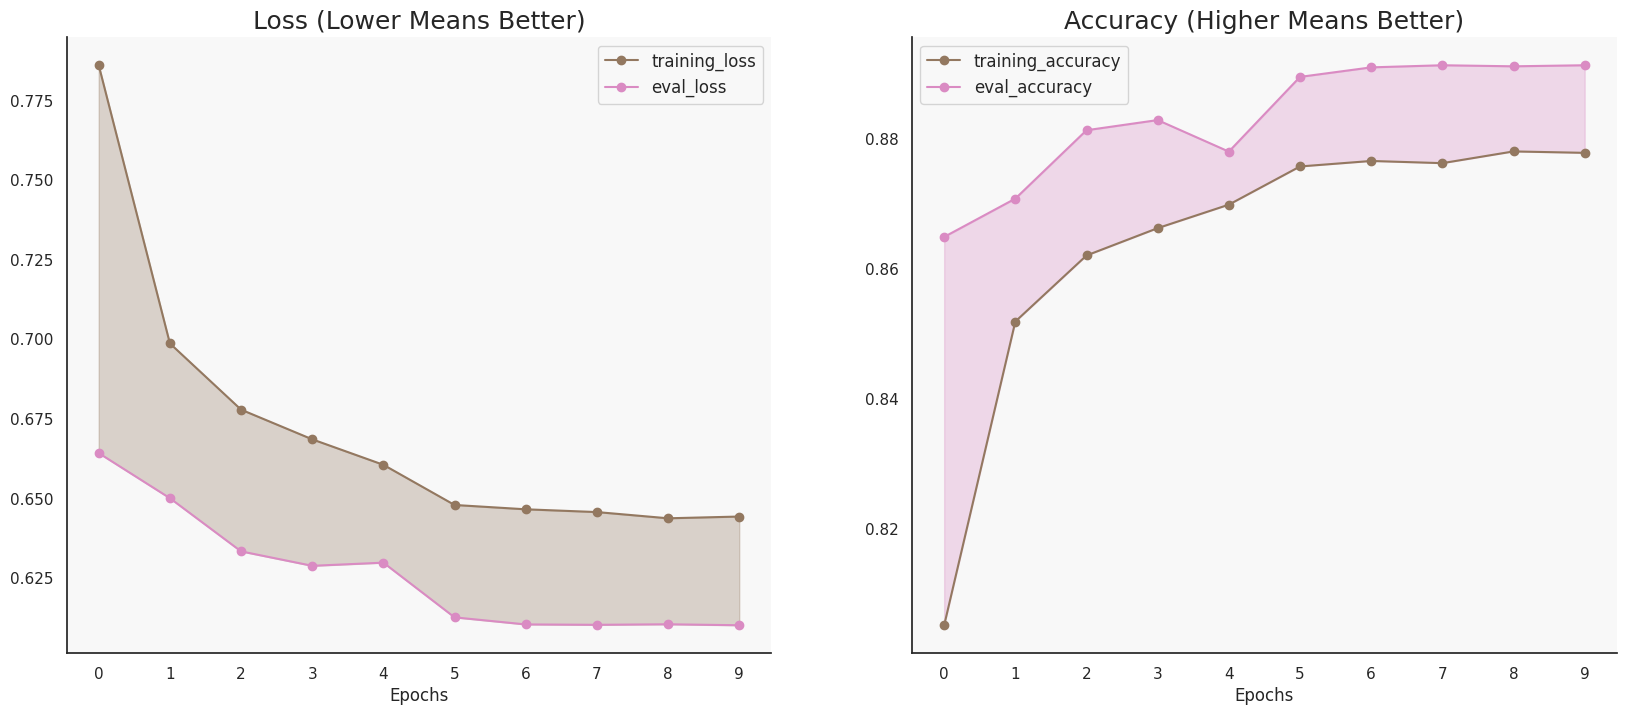

In [52]:
# Plot session training history 
plot_training_curves(session_history)

<div class="alert alert-block alert-info">
<h3>Observation</h3>
We see that our model was able to converge to a lower loss for both training and validation sets. We also observe that the model achieved a lower validation loss, but has yet to reach a plateau. This indecates that the model is still capable of achieving a lower loss, and potentially achieve improved performance.
</div>

<a id='6.2'></a>
### Plot Confusion Matrix

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes='auto', figsize=(10, 10), text_size=12): 
    # Define a custom color palette (dark-to-light shades)
    cmap = sns.color_palette(["#333333", "#503f3f", "#6d4b4b", "#a86464", "#e27c7c"])
    
    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Set seaborn theme
    sns.set_theme(style="white")
    plt.rcParams['axes.facecolor'] = '#f8f8f8'  # Light background
    
    # Plot setup
    plt.figure(figsize=figsize)
    disp = sns.heatmap(
        cm,
        annot=True,
        cmap=sns.light_palette("#6d4b4b", as_cmap=True),
        fmt='g',
        annot_kws={"size": text_size, "weight": "bold", "color": "black"},
        linewidths=0.5,
        linecolor='black',
        xticklabels=classes,
        yticklabels=classes,
        cbar=False  # Hide colorbar for cleaner look
    )

    # Aesthetic tuning
    disp.set_title('Confusion Matrix', fontsize=24, weight='bold', color='black')
    disp.set_xlabel('Predicted Label', fontsize=18, color='black')
    disp.set_ylabel('True Label', fontsize=18, color='black')
    disp.set_xticklabels(disp.get_xticklabels(), fontsize=12, color='black', rotation=0)
    disp.set_yticklabels(disp.get_yticklabels(), fontsize=12, color='black', rotation=0)

    sns.despine()
    plt.tight_layout()
    plt.show()


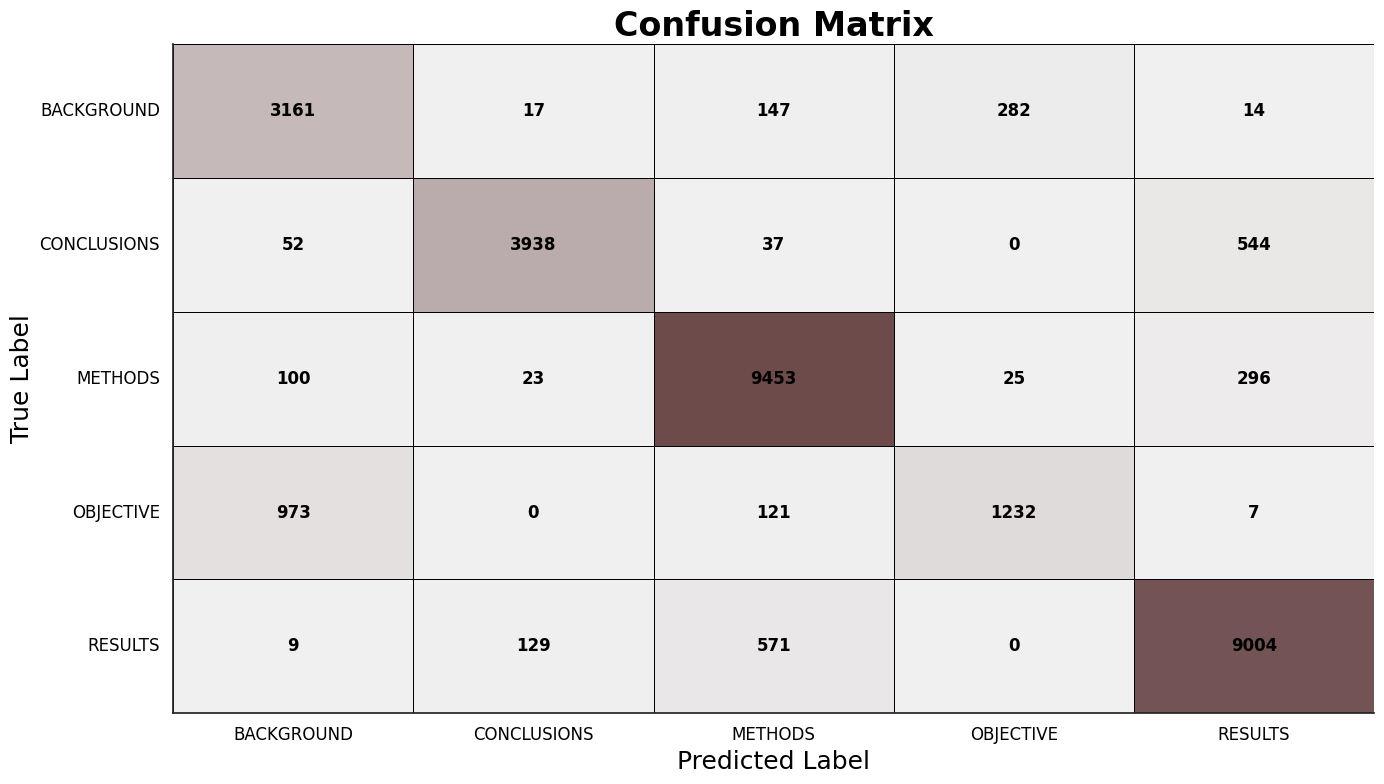

In [74]:
test_labels = [*map(test_ds.class_to_idx.get, test_ds.labels)]

plot_confusion_matrix(
    test_labels, 
    test_preds, 
    figsize=(14, 8),  
    classes=test_ds.classes)

<div class="alert alert-block alert-info">
<h3>Observation</h3>
We notice that the model struggles to segment BACKGROUND & OBJECTIVE related samples. This could be due to target similarity issues in the texts and should be a point of exploration.
</div>

<a id='6.4'></a>
### Inspect Classification Report

In [56]:
print(
    classification_report(
        test_labels, 
        test_preds, 
        target_names=test_ds.classes
    )
)

              precision    recall  f1-score   support

  BACKGROUND       0.74      0.87      0.80      3621
 CONCLUSIONS       0.96      0.86      0.91      4571
     METHODS       0.92      0.96      0.93      9897
   OBJECTIVE       0.80      0.53      0.64      2333
     RESULTS       0.91      0.93      0.92      9713

    accuracy                           0.89     30135
   macro avg       0.86      0.83      0.84     30135
weighted avg       0.89      0.89      0.89     30135



<div class="alert alert-block alert-info">
<h3>Observation</h3>
The F1-Score for OBJECTIVE and BACKGROUND highlights the issues with the related samples. However, the model's performance is on par with the results presented in the reseach paper which inspired this notebook.
</div>

<a id='6.5'></a>
### Record Classification Metrics

In [57]:
def generate_performance_scores(y_true, y_pred, y_probabilities):
    
    model_accuracy = accuracy_score(y_true, y_pred)
    top_3_accuracy = top_k_accuracy_score(
        y_true, y_probabilities, k=3
    )
    model_precision, model_recall, model_f1, _ = (
        precision_recall_fscore_support(
            y_true, y_pred, average="weighted"
        )
    )    
    model_matthews_corrcoef = matthews_corrcoef(y_true, y_pred)
    
    print('=============================================')
    print(f'\nPerformance Metrics:\n')
    print('=============================================')
    print(f'accuracy_score:\t\t{model_accuracy:.4f}\n')
    print('_____________________________________________')
    print(f'top_3_accuracy_score:\t{top_3_accuracy:.4f}\n')
    print('_____________________________________________')
    print(f'precision_score:\t{model_precision:.4f}\n')
    print('_____________________________________________')
    print(f'recall_score:\t\t{model_recall:.4f}\n')
    print('_____________________________________________')
    print(f'f1_score:\t\t{model_f1:.4f}\n')
    print('_____________________________________________')
    print(f'matthews_corrcoef:\t{model_matthews_corrcoef:.4f}\n')
    print('=============================================')
    
    preformance_scores = {
        'accuracy_score'       : model_accuracy,
        'top_3_accuracy'       : top_3_accuracy,
        'precision_score'      : model_precision,
        'recall_score'         : model_recall,
        'f1_score'             : model_f1,
        'matthews_corrcoef'    : model_matthews_corrcoef
    }
    return preformance_scores

In [58]:
# Generate DeBERTa model performance scores
model_performance = generate_performance_scores(
    test_labels,
    test_preds, 
    test_probs
)


Performance Metrics:

accuracy_score:		0.8889

_____________________________________________
top_3_accuracy_score:	0.9953

_____________________________________________
precision_score:	0.8906

_____________________________________________
recall_score:		0.8889

_____________________________________________
f1_score:		0.8864

_____________________________________________
matthews_corrcoef:	0.8509



<div class="alert alert-block alert-info">
<h3>Observation</h3>
Notice that the model achieves a Matthews Correlation Coefficient (MCC) of above 0.82 on the test set. A high MCC implies that the model's predictions are statistically of high quality and that the model does indeed generalise to unseen samples. Note that there is still room for improvements.
</div>

# 7 | Predict on Actual Real Abstract

<br>
Let's predict on a random abstract taken from a public medical research paper available on PubMed to see what the model predicts.

> Abstract taken from here: [Discovery and systematic characterization of risk variants and genes for coronary artery disease in over a million participants](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9729111/)

In [59]:
real_abstract_text = """The discovery of genetic loci associated with complex diseases has outpaced the elucidation of 
mechanisms of disease pathogenesis. Here we conducted a genome-wide association study (GWAS) 
for coronary artery disease (CAD) comprising 181,522 cases among 1,165,690 participants of 
predominantly European ancestry. We detected 241 associations, including 30 new loci. Cross-
ancestry meta-analysis with a Japanese GWAS yielded 38 additional new loci. We prioritized likely 
causal variants using functionally informed fine-mapping, yielding 42 associations with less than 
five variants in the 95% credible set. Similarity-based clustering suggested roles for early 
developmental processes, cell cycle signaling and vascular cell migration and proliferation in the 
pathogenesis of CAD. We prioritized 220 candidate causal genes, combining eight complementary 
approaches, including 123 supported by three or more approaches. Using CRISPR–Cas9, we 
experimentally validated the effect of an enhancer in MYO9B, which appears to mediate CAD risk by 
regulating vascular cell motility. Our analysis identifies and systematically characterizes >250 risk 
loci for CAD to inform experimental interrogation of putative causal mechanisms for CAD."""

In [60]:
# view the abstract
print(real_abstract_text)

The discovery of genetic loci associated with complex diseases has outpaced the elucidation of 
mechanisms of disease pathogenesis. Here we conducted a genome-wide association study (GWAS) 
for coronary artery disease (CAD) comprising 181,522 cases among 1,165,690 participants of 
predominantly European ancestry. We detected 241 associations, including 30 new loci. Cross-
ancestry meta-analysis with a Japanese GWAS yielded 38 additional new loci. We prioritized likely 
causal variants using functionally informed fine-mapping, yielding 42 associations with less than 
five variants in the 95% credible set. Similarity-based clustering suggested roles for early 
developmental processes, cell cycle signaling and vascular cell migration and proliferation in the 
pathogenesis of CAD. We prioritized 220 candidate causal genes, combining eight complementary 
approaches, including 123 supported by three or more approaches. Using CRISPR–Cas9, we 
experimentally validated the effect of an enhancer

In [61]:
############################################
# TODO: Create function to extract sentences 
#       from abstract for preprocessing.
############################################
real_abstract_preprocessed = """The discovery of genetic loci associated with complex diseases has outpaced the elucidation of mechanisms of disease pathogenesis .
Here we conducted a genome-wide association study (GWAS) for coronary artery disease (CAD) comprising 181,522 cases among 1,165,690 participants of predominantly European ancestry .
We detected 241 associations, including 30 new loci . 
Cross-ancestry meta-analysis with a Japanese GWAS yielded 38 additional new loci .
We prioritized likely causal variants using functionally informed fine-mapping, yielding 42 associations with less than five variants in the 95% credible set .
Similarity-based clustering suggested roles for early developmental processes, cell cycle signaling and vascular cell migration and proliferation in the pathogenesis of CAD .
We prioritized 220 candidate causal genes, combining eight complementary approaches, including 123 supported by three or more approaches .
Using CRISPR–Cas9, we experimentally validated the effect of an enhancer in MYO9B, which appears to mediate CAD risk by regulating vascular cell motility .
Our analysis identifies and systematically characterizes >250 risk loci for CAD to inform experimental interrogation of putative causal mechanisms for CAD ."""

In [62]:
# Split the abstract into it's lines as seen in the original paper
real_texts = [_  for _ in real_abstract_preprocessed.split('\n')]

# Preprocess texts
real_texts = [text_processor(_) for _ in real_texts]

In [63]:
real_texts

['The discovery of genetic loci associated with complex diseases has outpaced the elucidation of mechanisms of disease pathogenesis .',
 'Here we conducted a genome-wide association study (GWAS) for coronary artery disease (CAD) comprising ###,### cases among #,###,### participants of predominantly European ancestry .',
 'We detected ### associations, including ## new loci . ',
 'Cross-ancestry meta-analysis with a Japanese GWAS yielded ## additional new loci .',
 'We prioritized likely causal variants using functionally informed fine-mapping, yielding ## associations with less than five variants in the ##% credible set .',
 'Similarity-based clustering suggested roles for early developmental processes, cell cycle signaling and vascular cell migration and proliferation in the pathogenesis of CAD .',
 'We prioritized ### candidate causal genes, combining eight complementary approaches, including ### supported by three or more approaches .',
 'Using CRISPRCas#, we experimentally validate

In [64]:
def tokenize_text(text, tokenizer, max_len=CFG.MAX_LENGTH):
    tokenize_params = {
        'text'                  : text,
        'add_special_tokens'    : True, 
        'truncation'            : True,
        'padding'               : 'max_length', 
        'max_length'            : max_len,
        'return_tensors'        : 'pt'
    }
    return tokenizer(**tokenize_params)

abstract_tokens = tokenize_text(real_texts, tokenizer, max_len=CFG.MAX_LENGTH)

In [65]:
def infer_model(model, texts, device=CFG.DEVICE):
    # Set model into eval mode
    model.eval()
    
    n_lines = texts['input_ids'].shape[0]
    current_lines = torch.as_tensor([_ for _ in range(n_lines)])
    total_lines = torch.as_tensor([n_lines for _ in range(n_lines)])
    # Active inferene context manager
    with torch.inference_mode():
    
        # Load data onto target device
        current_lines = current_lines.to(device, dtype=torch.float32)
        total_lines = total_lines.to(device, dtype=torch.float32)
        tokens = {key:texts[key].to(device) for key in texts.keys()}
        
        # Feed-forward and compute metrics
        pred = model(tokens, current_lines, total_lines) 

        # Compute Probability
        predicted_probs = torch.softmax(pred, dim=1).cpu().numpy()

    return np.vstack(predicted_probs)

In [66]:
abstract_probabilities = infer_model(
    deberta_model, 
    abstract_tokens,
    device=CFG.DEVICE
)

abstract_probabilities

array([[0.6901965 , 0.03217551, 0.01959174, 0.22827399, 0.02976217],
       [0.14020249, 0.0568291 , 0.5613564 , 0.16222832, 0.07938366],
       [0.05088904, 0.0225915 , 0.30342382, 0.03525881, 0.58783686],
       [0.03395508, 0.02122736, 0.48378995, 0.03064507, 0.43038255],
       [0.01656509, 0.04280859, 0.33378783, 0.01642605, 0.5904124 ],
       [0.04045865, 0.18529078, 0.2291041 , 0.0334915 , 0.511655  ],
       [0.01248238, 0.07739516, 0.04014124, 0.01186974, 0.8581115 ],
       [0.0256618 , 0.8212204 , 0.06587715, 0.02692091, 0.06031969],
       [0.02031329, 0.8530991 , 0.09716575, 0.01826806, 0.01115377]],
      dtype=float32)

In [67]:
def display_segemented_abstract(abstract_texts, mask, probabilities, color=False):
    colors = {
        'BACKGROUND': 34,     # blue
        'OBJECTIVE': 35,      # magenta
        'METHODS': 32,        # green
        'RESULTS': 33,        # yellow
        'CONCLUSIONS': 31     # red
    }
    
    segmented_abstract = ""
    
    for text_line, text_mask, prediction_prob in zip(abstract_texts, mask, probabilities):
        if color:
            segmented_abstract += '\033[1;{}m{:<12s}\n\n{:<12s}\n\n\n'.format(
                colors[text_mask], f'{text_mask} | Probability: {prediction_prob:0.2f}', text_line)
        else:
            segmented_abstract += '{:<12s}\n {:<12s}\n'.format(text_mask, text_line[0])
            
    return segmented_abstract

In [68]:
abstract_predictions = np.argmax(abstract_probabilities, axis=1)
prediction_probabilities = [prob[_] for prob, _ in zip(abstract_probabilities, abstract_predictions)]

mask = [test_ds.classes[_] for _ in abstract_predictions]

In [69]:
prediction_probabilities

[0.6901965,
 0.5613564,
 0.58783686,
 0.48378995,
 0.5904124,
 0.511655,
 0.8581115,
 0.8212204,
 0.8530991]

In [70]:
# Generate Segmented Abstract
segmented_abstract = display_segemented_abstract(
    [str(_) for _ in real_texts], 
    mask, 
    prediction_probabilities, 
    color=True
)

# View Segmented Abstract
print(segmented_abstract)

BACKGROUND | Probability: 0.69

The discovery of genetic loci associated with complex diseases has outpaced the elucidation of mechanisms of disease pathogenesis .


METHODS | Probability: 0.56

Here we conducted a genome-wide association study (GWAS) for coronary artery disease (CAD) comprising ###,### cases among #,###,### participants of predominantly European ancestry .


RESULTS | Probability: 0.59

We detected ### associations, including ## new loci . 


METHODS | Probability: 0.48

Cross-ancestry meta-analysis with a Japanese GWAS yielded ## additional new loci .


RESULTS | Probability: 0.59

We prioritized likely causal variants using functionally informed fine-mapping, yielding ## associations with less than five variants in the ##% credible set .


RESULTS | Probability: 0.51

Similarity-based clustering suggested roles for early developmental processes, cell cycle signaling and vascular cell migration and proliferation in the pathogenesis of CAD .


RESULTS | Probability: 0

<div class="alert alert-block alert-info">
<h3>Observation</h3>
Notice that the model is resonably confident in all of the predictions. We also observe a logical flow among the segmented sentences.
</div>